# Pull graphs for Ub Ligases

In [21]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import os
import json

from indra.databases.hgnc_client import get_hgnc_id, get_hgnc_name
from protmapper import uniprot_client

from indra_cogex.client import Neo4jClient

from MScausality.graph_construction.utils import get_neighbor_network

## Measured Ligases

In [2]:
data = pd.read_csv('/Users/kohler.d/Library/CloudStorage/OneDrive-NortheasternUniversity/Northeastern/Research/Barnett_project/Data/measured_ub_ligase.csv')
genes = data["Protein"].str.split("_", n=1, expand=True).loc[:, 0].values

In [61]:
quant_data = pd.read_csv(
    '/Users/kohler.d/Library/CloudStorage/OneDrive-NortheasternUniversity/Northeastern/Research/Barnett_project/Data/quant_data.csv'
    )
quant_data.loc[:, "Gene"] = quant_data["Protein"].str.split(
    "_", n=1, expand=True).loc[:, 0].values
quant_data = quant_data.pivot(index='originalRUN', 
                              columns='Gene', 
                              values='LogIntensities')

hl_data = pd.read_csv(
    '/Users/kohler.d/Library/CloudStorage/OneDrive-NortheasternUniversity/Northeastern/Research/Barnett_project/Data/half_life_data.csv'
    )
hl_data.loc[:, "Gene"] = hl_data["ProteinName"].str.split(
    "_", n=1, expand=True).loc[:, 0].values
hl_data = hl_data.pivot(index='Run', 
                        columns='Gene', 
                        values='LogIntensities')

### Pull INDRA data

In [7]:
hgnc_ids = set()
failed = set()
for gene_id in genes:
    hgnc_id = get_hgnc_id(gene_id)

    if hgnc_id:
        hgnc_ids.add(hgnc_id)
    else:
        failed.add(gene_id)

client = Neo4jClient(url=os.getenv("API_URL"), 
                        auth=(os.getenv("USER"), 
                            os.getenv("PASSWORD"))
                    )

hgnc_curies = [("hgnc", gene_id) for gene_id in hgnc_ids if gene_id is not None]

query_results = get_neighbor_network(nodes=hgnc_curies, 
                                     client=client,
                                     upstream=False,
                                     downstream=True,
                                     minimum_evidence_count=1)


columns = [
    "source_hgnc_id",
    "source_hgnc_symbol",
    "relation",
    "target_hgnc_id",
    "target_hgnc_symbol",
    "stmt_hash",
    "evidence_count",
    "source_counts",
    ]

rows = []
for relation in query_results:
    rows.append(
        (
            relation.source_id,
            get_hgnc_name(relation.source_id),
            # source_uniprot,
            relation.data["stmt_type"],
            relation.target_id,
            get_hgnc_name(relation.target_id),
            # target_uniprot,
            relation.data["stmt_hash"],
            sum(json.loads(relation.data["source_counts"]).values()),
            relation.data["source_counts"],
        )
    )
indra_stmts = pd.DataFrame(rows, columns=columns)
indra_stmts.head()

,source_hgnc_id,source_hgnc_symbol,relation,target_hgnc_id,target_hgnc_symbol,stmt_hash,evidence_count,source_counts
0,4868,HERC2,DecreaseAmount,8101,OCA2,-15700386236288887,3,"{""reach"": 3}"
1,4868,HERC2,DecreaseAmount,7671,NCOA4,33318729733845569,1,"{""medscan"": 1}"
2,4868,HERC2,DecreaseAmount,34410,NEURL4,-21508722853083910,3,"{""medscan"": 1, ""signor"": 2}"
3,4868,HERC2,IncreaseAmount,20059,USP33,34797823996414498,1,"{""reach"": 1}"
4,4868,HERC2,DecreaseAmount,19715,CLSPN,9311066943374755,2,"{""medscan"": 2}"


In [10]:
len(indra_stmts)
indra_stmts["relation"].unique()
len(indra_stmts[indra_stmts["relation"] == "DecreaseAmount"])

1914

### Graph

#### All edges

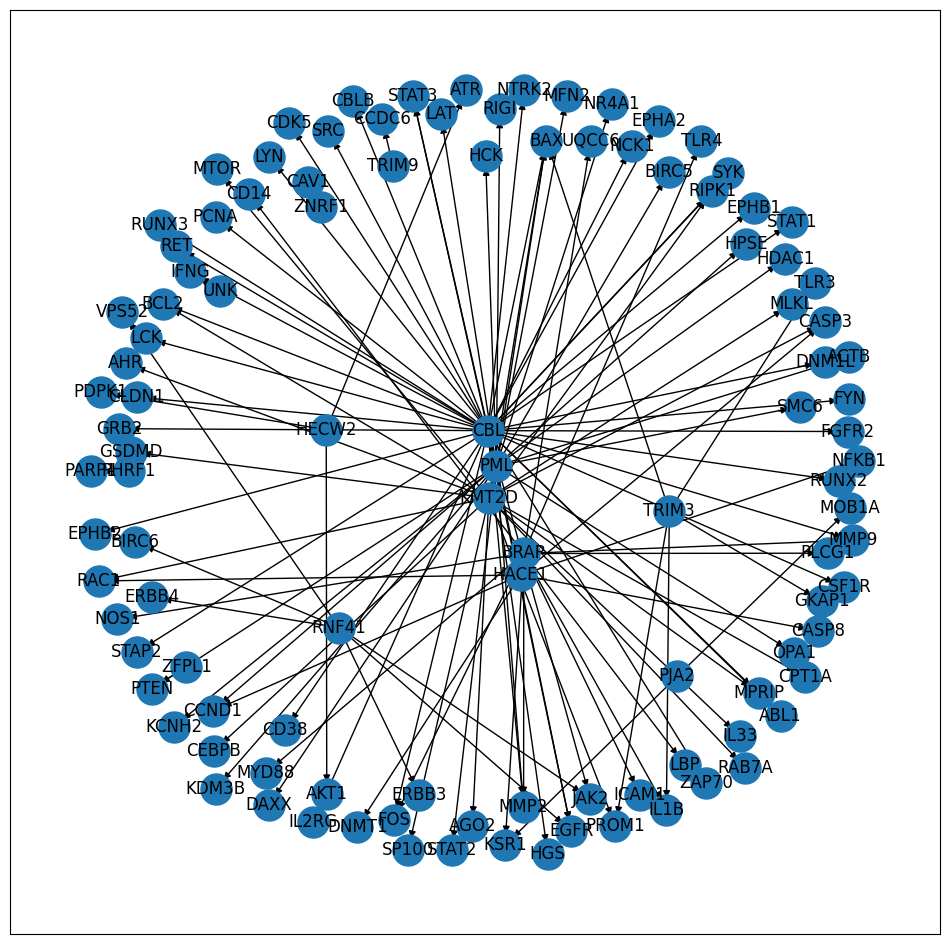

In [66]:
nx_data = indra_stmts[
    (indra_stmts["relation"] == "DecreaseAmount")# & \
                      ].loc[:, ["source_hgnc_symbol", "target_hgnc_symbol"]# (indra_stmts["evidence_count"] > 1)
                          ].drop_duplicates(ignore_index=True)

nx_data.loc[:, "source_ligase"] = np.where(
    nx_data.loc[:, "source_hgnc_symbol"].isin(genes), "Ligase", "Other")
nx_data.loc[:, "target_ligase"] = np.where(
    nx_data.loc[:, "target_hgnc_symbol"].isin(genes), "Ligase", "Other")

nx_data = nx_data.loc[nx_data["source_hgnc_symbol"].isin(np.random.choice(genes, size=20))]

nx_data.to_csv('/Users/kohler.d/Library/CloudStorage/OneDrive-NortheasternUniversity/Northeastern/Research/Barnett_project/Data/test.csv')

G = nx.DiGraph()
for i in range(len(nx_data)):
    if nx_data.iloc[i, 0] is None or nx_data.iloc[i, 1] is None:
        pass
    else:
        if nx_data.iloc[i, 0] in quant_data.columns and \
            nx_data.iloc[i, 1] in quant_data.columns:
            G.add_edge(nx_data.iloc[i, 0], nx_data.iloc[i, 1])

fig, ax = plt.subplots(figsize=(12, 12))
pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G, pos, node_size = 500)
nx.draw_networkx_labels(G, pos)
nx.draw_networkx_edges(G, pos, arrows=True)
plt.show()

In [97]:
G.remove_edge("CBLB", "NEDD4")
G.remove_edge('TRAF6', 'TRAF3')
G.remove_edge('TRAF6', 'BIRC2')
G.remove_edge('BIRC2', "TRAF3")
G.remove_edge('BIRC2', "TRAF2")
G.remove_edge('AMFR', 'SYVN1')
G.remove_edge('TRAF3', 'TRAF2')
G.remove_edge('BRCA1', 'HERC2')
G.remove_edge('BRCA1', 'BARD1')
G.remove_edge('XIAP', 'BIRC2')
[i for i in nx.simple_cycles(G)]

[]

#### Ubiq edges

37


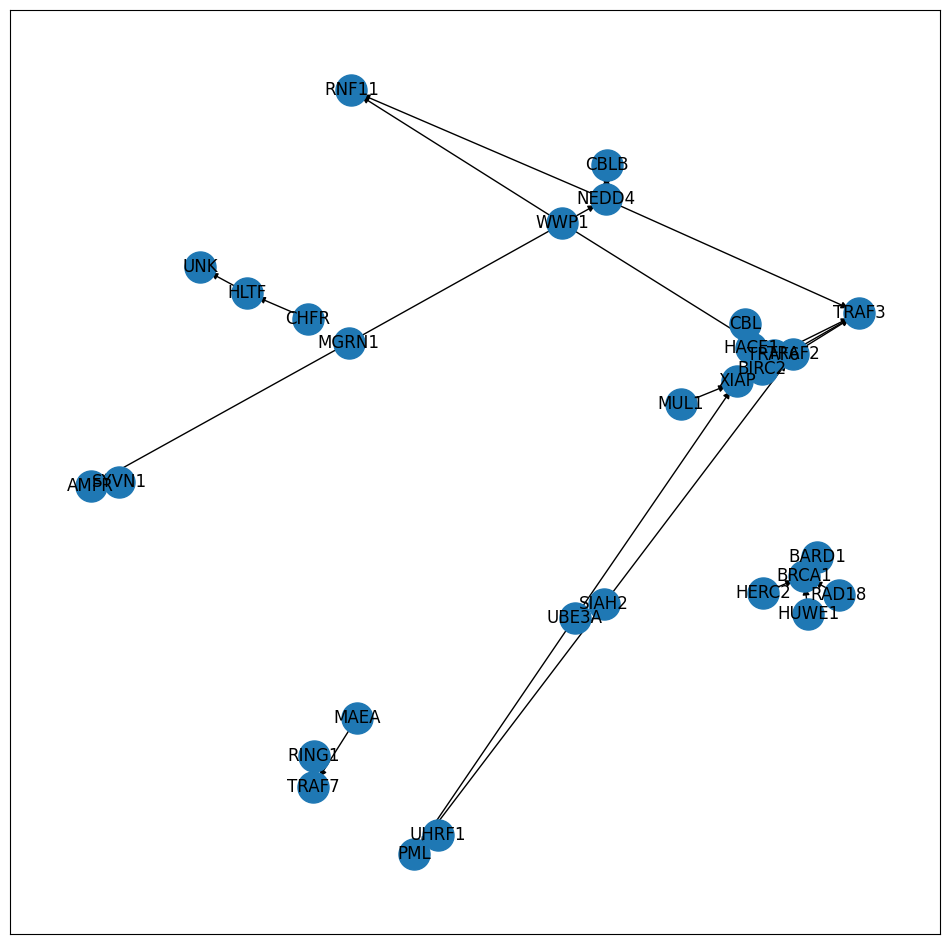

In [59]:
ub_stmts = indra_stmts[indra_stmts["relation"] == "Ubiquitination"]
nx_data = ub_stmts.loc[:, ["source_hgnc_symbol", "target_hgnc_symbol"]
                          ].drop_duplicates(ignore_index=True)
print(len(nx_data))
nx_data.to_csv('/Users/kohler.d/Library/CloudStorage/OneDrive-NortheasternUniversity/Northeastern/Research/Barnett_project/Data/test.csv')

G = nx.DiGraph()
for i in range(len(nx_data)):
    G.add_edge(nx_data.iloc[i, 0], nx_data.iloc[i, 1])

fig, ax = plt.subplots(figsize=(12, 12))    
pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G, pos, node_size = 500)
nx.draw_networkx_labels(G, pos)
nx.draw_networkx_edges(G, pos, arrows=True)
plt.show()

## All Ligases

In [39]:
data = pd.read_csv('/Users/kohler.d/Library/CloudStorage/OneDrive-NortheasternUniversity/Northeastern/Research/Barnett_project/Data/Ubiquitin_ligases.csv')
genes = data["Gene Symbol"].values

378

### Pull INDRA data

In [40]:
hgnc_ids = set()
failed = set()
for gene_id in genes:
    hgnc_id = get_hgnc_id(gene_id)

    if hgnc_id:
        hgnc_ids.add(hgnc_id)
    else:
        failed.add(gene_id)

client = Neo4jClient(url=os.getenv("API_URL"), 
                        auth=(os.getenv("USER"), 
                            os.getenv("PASSWORD"))
                    )

hgnc_curies = [("hgnc", gene_id) for gene_id in hgnc_ids if gene_id is not None]

query_results = query_between_relationships(hgnc_curies, client,
                                            ["IncreaseAmount", 
                                             "DecreaseAmount", 
                                             "Ubiquitination"])

columns = [
    "source_hgnc_id",
    "source_hgnc_symbol",
    "relation",
    "target_hgnc_id",
    "target_hgnc_symbol",
    "stmt_hash",
    "evidence_count",
    "source_counts",
    ]

rows = []
for relation in query_results:
    rows.append(
        (
            relation.source_id,
            get_hgnc_name(relation.source_id),
            # source_uniprot,
            relation.data["stmt_type"],
            relation.target_id,
            get_hgnc_name(relation.target_id),
            # target_uniprot,
            relation.data["stmt_hash"],
            sum(json.loads(relation.data["source_counts"]).values()),
            relation.data["source_counts"],
        )
    )
indra_stmts = pd.DataFrame(rows, columns=columns)
indra_stmts.head()

,source_hgnc_id,source_hgnc_symbol,relation,target_hgnc_id,target_hgnc_symbol,stmt_hash,evidence_count,source_counts
0,4868,HERC2,DecreaseAmount,1100,BRCA1,-18729485592279876,4,"{""reach"": 2, ""medscan"": 2}"
1,4868,HERC2,Ubiquitination,1100,BRCA1,-25226675137680296,1,"{""reach"": 1}"
2,4868,HERC2,Ubiquitination,1100,BRCA1,20256827776016893,10,"{""ubibrowser"": 1, ""sparser"": 5, ""reach"": 2, ""m..."
3,16803,UBE3C,DecreaseAmount,16807,SMURF1,27785834121918229,1,"{""medscan"": 1}"
4,1066,BMI1,DecreaseAmount,12929,PCGF2,-7398788668523538,2,"{""reach"": 1, ""medscan"": 1}"


### Graph

#### All edges

247


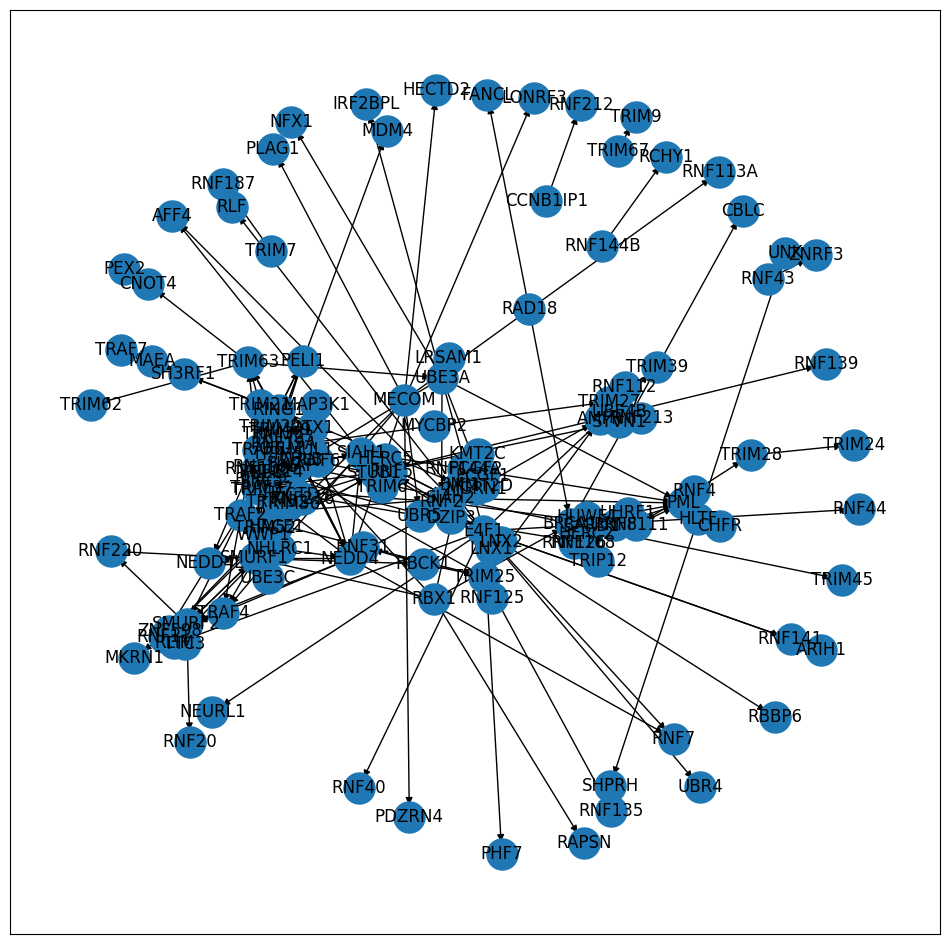

In [41]:
nx_data = indra_stmts.loc[:, ["source_hgnc_symbol", "target_hgnc_symbol"]
                          ].drop_duplicates(ignore_index=True)
print(len(nx_data))

G = nx.DiGraph()
for i in range(len(nx_data)):
    G.add_edge(nx_data.iloc[i, 0], nx_data.iloc[i, 1])

fig, ax = plt.subplots(figsize=(12, 12))    
pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G, pos, node_size = 500)
nx.draw_networkx_labels(G, pos)
nx.draw_networkx_edges(G, pos, arrows=True)
plt.show()

#### Ubiq edges

151


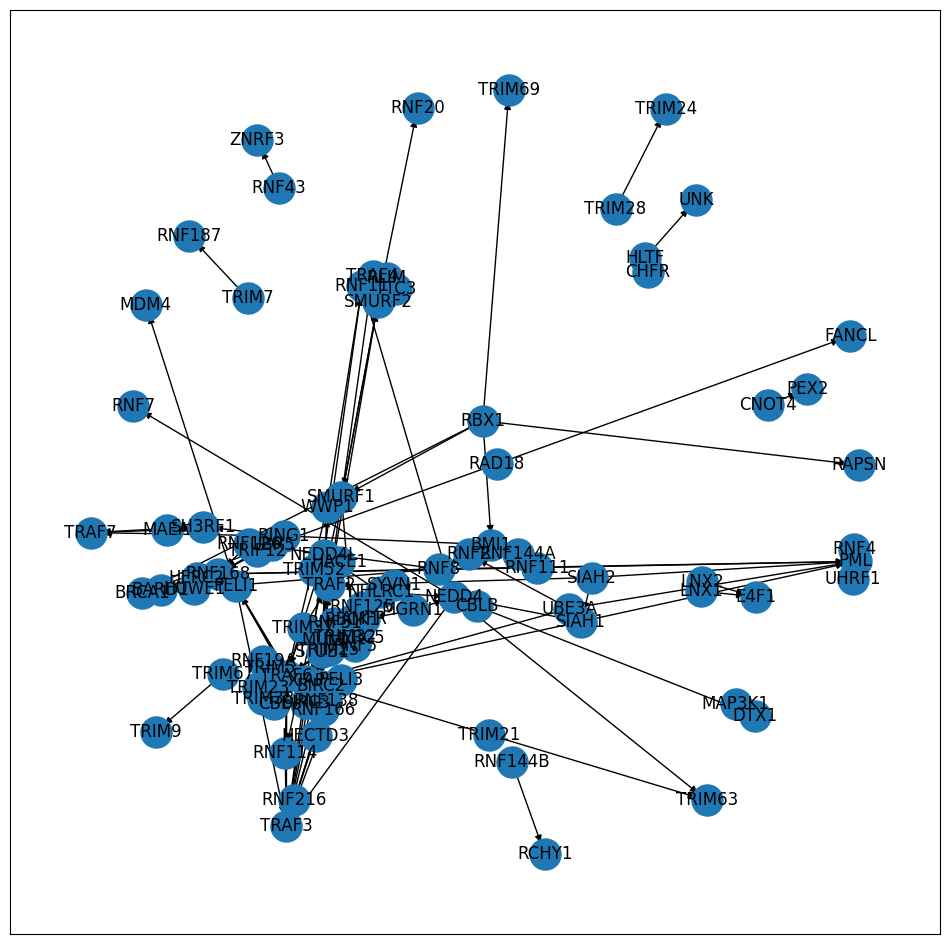

In [45]:
ub_stmts = indra_stmts[indra_stmts["relation"] == "Ubiquitination"]
nx_data = ub_stmts.loc[:, ["source_hgnc_symbol", "target_hgnc_symbol"]
                          ].drop_duplicates(ignore_index=True)
print(len(nx_data))
nx_data.to_csv('/Users/kohler.d/Library/CloudStorage/OneDrive-NortheasternUniversity/Northeastern/Research/Barnett_project/Data/test.csv')

G = nx.DiGraph()
for i in range(len(nx_data)):
    G.add_edge(nx_data.iloc[i, 0], nx_data.iloc[i, 1])

fig, ax = plt.subplots(figsize=(12, 12))    
pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G, pos, node_size = 500)
nx.draw_networkx_labels(G, pos)
nx.draw_networkx_edges(G, pos, arrows=True)
plt.show()

## Regressions

In [295]:
import statsmodels.api as sm

var_list = list()
x_var = list()

for node in G.nodes:
    incoming_edges = G.in_edges(node, data=True)
    incoming_edges = [e[0] for e in incoming_edges]
    if len(incoming_edges) > 0:
        node = str(node)
        # if all([i in incoming_edges for i in quant_data.columns]):
        temp_X_data = quant_data.loc[:, incoming_edges]
        if node in hl_data.columns:
            temp_y_data = hl_data.loc[:, node]

            temp_data = pd.concat([temp_X_data, temp_y_data], 
                                axis=1).dropna()
            if len(temp_data) > 5:
                temp_data = (temp_data-temp_data.min())/(temp_data.max()-temp_data.min())
                
                X = temp_data.loc[:, incoming_edges]
                X.insert(0, "Index", [1 for _ in range(len(X))], True)
                y = temp_data.loc[:, node]

                ols = sm.OLS(y.values, X.values)
                ols_result = ols.fit()
                # var_mat = ols_result.cov_params()

                # for i in range(1, 1+len(incoming_edges)):
                #     var_list.append(var_mat[i, i])
                var_list.append(ols_result.mse_resid )
                for i in range(len(incoming_edges)):
                    x_var.append(temp_data.loc[:, incoming_edges].var()[i])


/var/folders/v7/y32f7x653v9cx3jmt128bnhh0000gp/T/ipykernel_17458/3826359974.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x_var.append(temp_data.loc[:, incoming_edges].var()[i])
/var/folders/v7/y32f7x653v9cx3jmt128bnhh0000gp/T/ipykernel_17458/3826359974.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x_var.append(temp_data.loc[:, incoming_edges].var()[i])
/var/folders/v7/y32f7x653v9cx3jmt128bnhh0000gp/T/ipykernel_17458/3826359974.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame b

In [296]:
mean_error = np.median([i for i in var_list if np.isfinite(i)])
mean_xvar = np.median([i for i in x_var if np.isfinite(i)])
print(mean_error)
print(mean_xvar)

0.07412030090061925
0.073834607145313


<Axes: >

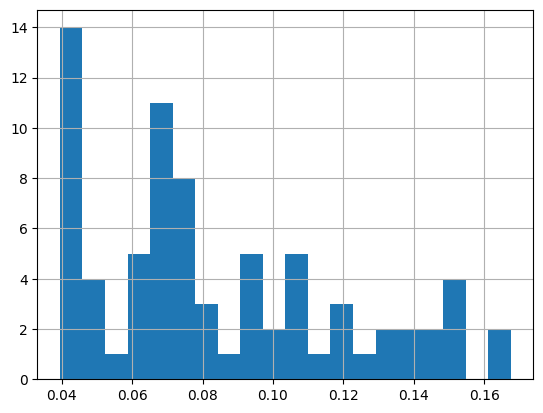

In [297]:
pd.Series([i for i in x_var if np.isfinite(i)]).hist(bins=20)

<Axes: >

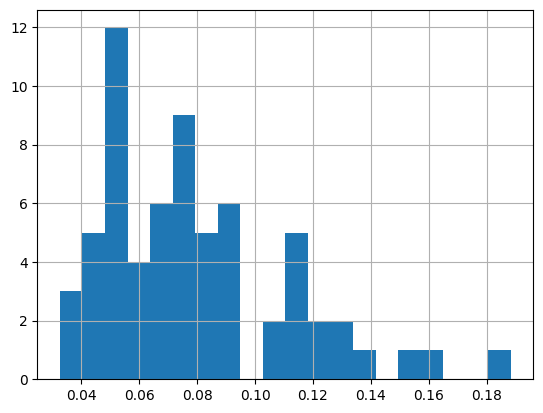

In [298]:
pd.Series([i for i in var_list if np.isfinite(i)]).hist(bins=20)

In [299]:
from scipy.stats import norm

# Define significance level (alpha) and desired power (1 - beta)
alpha = 0.05  # for a 5% significance level
power = 0.80  # for 80% power

# Calculate Z-scores
Z_alpha = norm.ppf(1 - alpha / 2)   # Z-score for two-tailed significance level
Z_beta = norm.ppf(power)            # Z-score for power

# Calculate sample size
def sample_size(beta, error_var, X_var):
    return (((Z_alpha + Z_beta)**2)*error_var) / ((beta**2)*X_var)

coef_range = np.arange(.1, 2, .01)
estimated_sample_size = [sample_size(i, mean_error, mean_xvar) for i in coef_range]

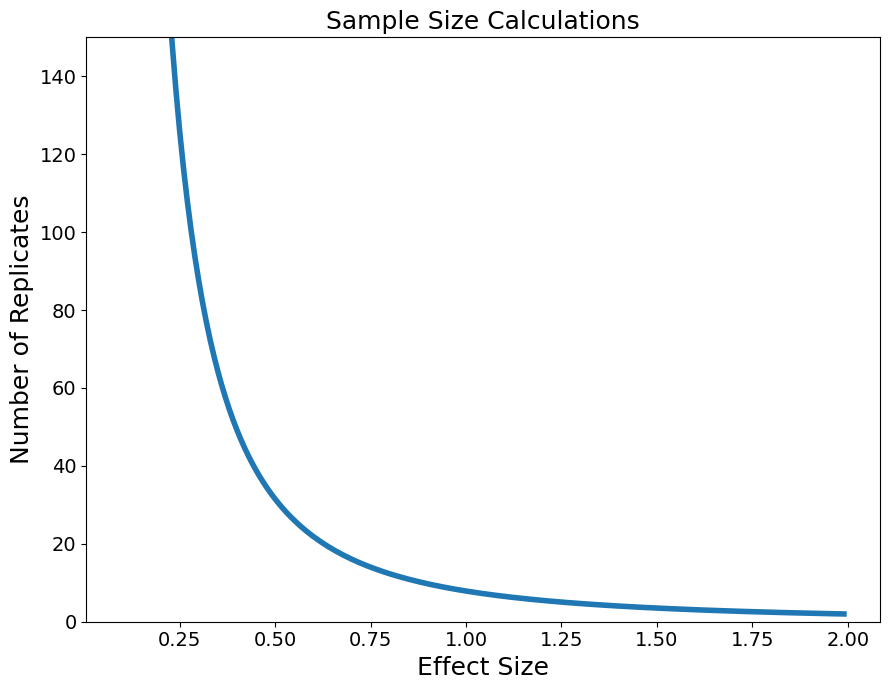

In [300]:
fig, ax = plt.subplots(figsize=(9,7), dpi=100)

ax.plot(coef_range, estimated_sample_size, linewidth=4)
ax.set_xlabel("Effect Size", fontsize=18)
ax.set_ylabel("Number of Replicates", fontsize=18)
ax.set_title("Sample Size Calculations", fontsize=18)
ax.set_ylim(0,150)

plt.xticks(fontsize=14, color="black")
plt.yticks(fontsize=14, color="black")
plt.tight_layout()


In [301]:
sample_size(.4, mean_error, mean_xvar)

49.24531244015505

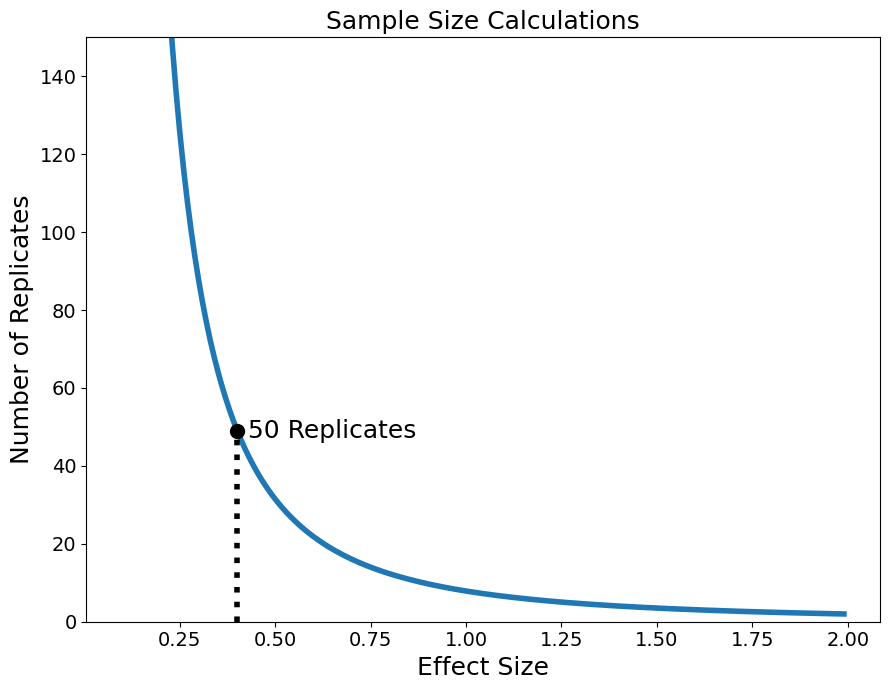

In [302]:
fig, ax = plt.subplots(figsize=(9,7), dpi=100)

ax.scatter(x=.4, y=49, color="black", s=100, zorder=2)
ax.plot(coef_range, estimated_sample_size, linewidth=4, zorder=1)
ax.set_xlabel("Effect Size", fontsize=18)
ax.set_ylabel("Number of Replicates", fontsize=18)
ax.set_title("Sample Size Calculations", fontsize=18)
ax.annotate('50 Replicates', xy=(.43, 52), xytext=(.43, 52), 
            horizontalalignment='left', verticalalignment='top', size=18)
ax.vlines(.4, 0, 50, linestyles='dotted', linewidth=4, color="black")


ax.set_ylim(0,150)

plt.xticks(fontsize=14, color="black")
plt.yticks(fontsize=14, color="black")
plt.tight_layout()
